In [8]:
import numpy as np
from matplotlib import pyplot as plt
import h5py as h5
from scipy.optimize import least_squares

### Read node masses

In [26]:
file = h5.File('../output/lcdm.h5')
nodes = [file[str(s)]["nodes"][:] for s in range(3)]
t = [file[str(s)].attrs["time"] for s in range(3)]
L = file.attrs["L"]
file.close()

### Define log-normal function

In [27]:
def log_normal(A, mu, sigma):
    def f(x):
        y = np.log(x / mu)
        return A * np.exp(-y**2 / (2 * sigma**2))
    
    return f

### Set parameters

In [28]:
lower_bound = -1.3
upper_bound = 2.7
N = 52
V = L**3

### Produce plot

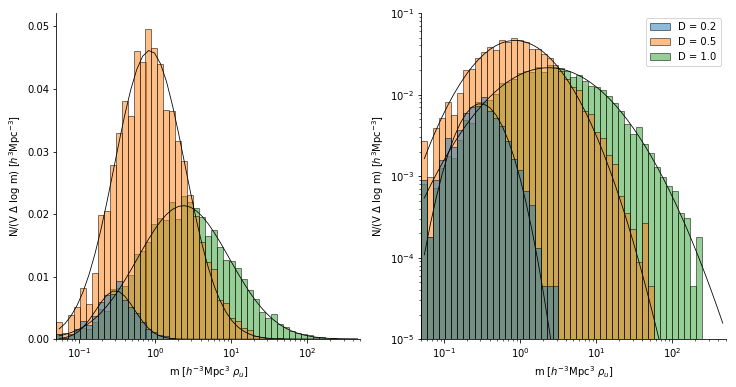

In [29]:
bins = np.logspace(lower_bound, upper_bound, N)
bin_width = bins[1:] - bins[:-1]
logbin_width = np.log(bins[1:] / bins[:-1])
x = np.sqrt(bins[:-1]) * np.sqrt(bins[1:])

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[1].set_yscale("log")

for ax in axes:
    ax.set_xscale("log")
    ax.set_xlim(10**lower_bound, 10**upper_bound)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.set_xlabel("m [$h^{-3}{\\rm Mpc}^3\\ \\rho_u$]")
    ax.set_ylabel("N/(V $\Delta$ log m) [$h^3{\\rm Mpc}^{-3}$]")

for i in range(3):
    masses = nodes[i][np.where(nodes[i]['node_type'] == 4)]['mass']
    hist = np.histogram(masses, bins=bins)
    y = hist[0] / logbin_width / V
    
    with np.errstate(invalid='ignore'):
        fit = least_squares(
            lambda args: log_normal(*args)(x) - y,
            np.ones(3))
    
    for ax in axes:
        ax.bar(x, y, width=bin_width,
               label="D = {}".format(t[i]),
               alpha=0.5, edgecolor='k', zorder=-i)
        ax.plot(x, log_normal(*fit.x)(x), c='k', lw=0.8, zorder=10)

axes[1].legend()
axes[1].set_ylim(1e-5, 1e-1)
fig.savefig('mass-functions.svg', bbox_inches='tight')